In [2]:
# Importing importnt libraries.

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os

# NLTK VADER for sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ketanaggarwal/nltk_data...


We have imported all the necessary libraries which we required in order to build this stock sentiment analyser.

we are using libraries:
- pandas [For Working on DataFrame]
- BS4 for beautiful soup which allows us to store data of a web page
- Matplotlib for the visulation of the data using graph
- nltk [Natual Language Tool Kit] for analysing the language which helps us to calculate the sentiment score


In [32]:
from matplotlib import bezier


finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['AMZN', 'TSLA', 'AAPL', 'TWTR', 'F', 'MSFT', 'GS']
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)
    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    
    # Add the table to our dictionary
    news_tables[ticker] = news_table

Here we given the site URL from which we are takking the data.

Tickers are the Stocks which we are monitoring.

- TSLA [Tesla]
- MSFT [Microsoft]
- AAPL [Apple]
- AMZN [Amazon]
- TWTR [Twitter]
- F [Ford]
- GS [Goldman Scachs]

In [33]:
# Read one single day of headlines for ‘AMZN’ 
amzn = news_tables['AMZN']

# Get all the table rows tagged in HTML with <tr> into ‘amzn_tr’
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    
    # Read the text of the element ‘a’ into ‘link_text’
    a_text = table_row.a.text
    
    # Read the text of the element ‘td’ into ‘data_text’
    td_text = table_row.td.text
    
    # Print the contents of ‘link_text’ and ‘data_text’ 
    print(a_text)
    print(td_text)
    
    # Exit after printing 4 rows of data
    if i == 3:
        break

Amazon Prime Day alternatives: The best deals at Target, Best Buy, and Macy's
Jul-09-22 02:18PM  
These Two Retail Giants Just Might Be Inflation-Proof -- Here's Why
11:41AM  
Is It Too Late to Buy Kornit Digital Stock?
11:24AM  
Costco is dominating retail as economy slows
08:25AM  


In [34]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element
        
        if len(date_scrape) == 1:
                    time = date_scrape[0]            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
            ticker = file_name.split('_')[0]
                
            # Append ticker, date, time and headline as a list to the 'parsed_news' list
            parsed_news.append([ticker, date, time, text])
                
        parsed_news[:5] # print first 5 rows of news

In [35]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date
# display(parsed_and_scored_news)
parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2022-07-09,02:18PM,Amazon Prime Day alternatives: The best deals ...,0.00,0.498,0.502,0.8779
1,AMZN,2022-07-08,10:27PM,The Top CEOs: Kudos to 24 Game-Changing Corpor...,0.00,0.579,0.421,0.6249
2,AMZN,2022-07-07,06:46PM,Why Amazon Stock Climbed Today,0.00,0.702,0.298,0.1779
3,AMZN,2022-07-06,10:26PM,Amazon (AMZN) Takes Equity Stake in Grubhub,0.00,0.779,0.221,0.1779
4,TSLA,2022-07-10,04:30AM,Dow Jones Futures: Market Faces Test It's Fail...,0.18,0.820,0.000,-0.5106


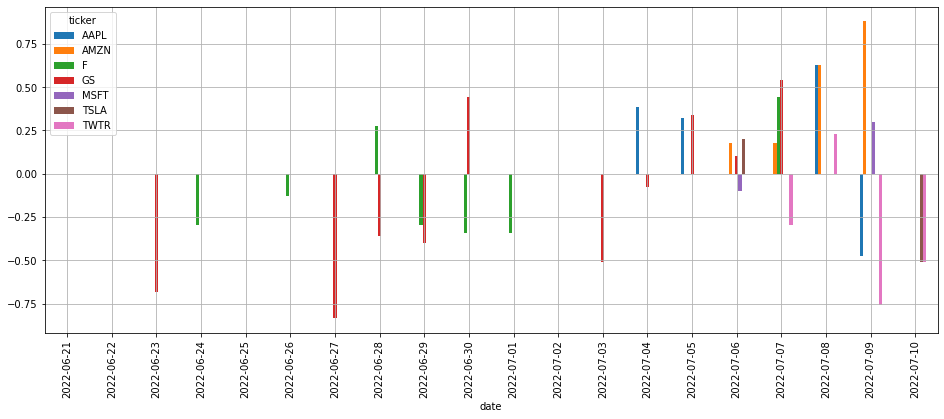

In [36]:
plt.rcParams['figure.figsize'] = [16, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

Here We are plotting the Graph Which shows the people sentiments while according to these particular stocks.